# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo. **Usar como benchmark la media de los ultimos 7 dias**.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

### Importar librerias ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost

import warnings
warnings.filterwarnings("ignore")

### Cargar datasets ###

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')

### Revisar estructura de cada datasets ###

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [6]:
data_2016.info()
data_2016.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,NO COBRADO,32
1,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,AUPASS,9
2,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,NO COBRADO,1
3,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EFECTIVO,4
4,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EXENTO,3


In [7]:
dict_df={2019:data_2019, 2018:data_2018, 2017:data_2017,2016:data_2016}


def revisar_columnas_por_anio(dict,columna):

    for anio,df in dict_df.items():

        print("\n\033[1m Registros unicos de la variable "+columna+" para el año " + str(anio) + " son:\033[0m")
        print(df[columna].unique())

In [8]:
revisar_columnas_por_anio(dict_df,'estacion')


 Registros unicos de la variable estacion para el año 2019 son:
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

 Registros unicos de la variable estacion para el año 2018 son:
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

 Registros unicos de la variable estacion para el año 2017 son:
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

 Registros unicos de la variable estacion para el año 2016 son:
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [9]:
revisar_columnas_por_anio(dict_df,'sentido')


 Registros unicos de la variable sentido para el año 2019 son:
['Centro' 'Provincia']

 Registros unicos de la variable sentido para el año 2018 son:
['Centro' 'Provincia']

 Registros unicos de la variable sentido para el año 2017 son:
['Centro' 'Provincia']

 Registros unicos de la variable sentido para el año 2016 son:
['Centro' 'Provincia']


In [10]:
revisar_columnas_por_anio(dict_df,'tipo_vehiculo')


 Registros unicos de la variable tipo_vehiculo para el año 2019 son:
['Liviano' 'Pesado']

 Registros unicos de la variable tipo_vehiculo para el año 2018 son:
['Liviano' 'Pesado']

 Registros unicos de la variable tipo_vehiculo para el año 2017 son:
['Liviano' 'Pesado']

 Registros unicos de la variable tipo_vehiculo para el año 2016 son:
['Liviano' 'Pesado']


In [11]:
revisar_columnas_por_anio(dict_df,'forma_pago')


 Registros unicos de la variable forma_pago para el año 2019 son:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']

 Registros unicos de la variable forma_pago para el año 2018 son:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']

 Registros unicos de la variable forma_pago para el año 2017 son:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']

 Registros unicos de la variable forma_pago para el año 2016 son:
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

### Consolidado, filtrado y preparación del dataset###

In [12]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat(dict_df.values())

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]
dataset=dataset.drop_duplicates()

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [13]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True)

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)

dataset.reset_index(drop=True, inplace = True)

dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Viernes,Centro,Liviano,14,2016-01-01 00:00:00
1,Viernes,Centro,Pesado,3,2016-01-01 00:00:00
2,Viernes,Provincia,Liviano,66,2016-01-01 00:00:00
3,Viernes,Provincia,Pesado,1,2016-01-01 00:00:00
4,Viernes,Provincia,Pesado,4,2016-01-01 00:00:00
...,...,...,...,...,...
317220,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
317221,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
317222,Martes,Centro,Liviano,580,2019-12-31 22:00:00
317223,Martes,Centro,Liviano,214,2019-12-31 23:00:00


# Analisis exploratorio de datos #

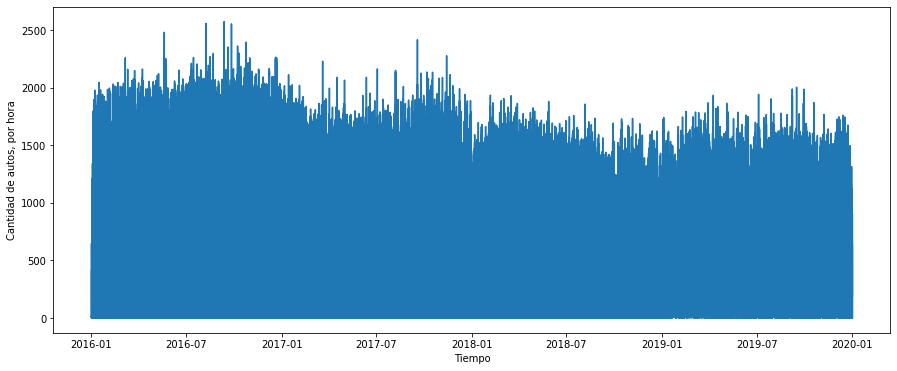

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [15]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
diario.reset_index(inplace=True)
print(diario.shape)
diario.head()

(1461, 2)


,fecha,cantidad_pasos
0,2016-01-01,25574
1,2016-01-02,36113
2,2016-01-03,37178
3,2016-01-04,50281
4,2016-01-05,49883


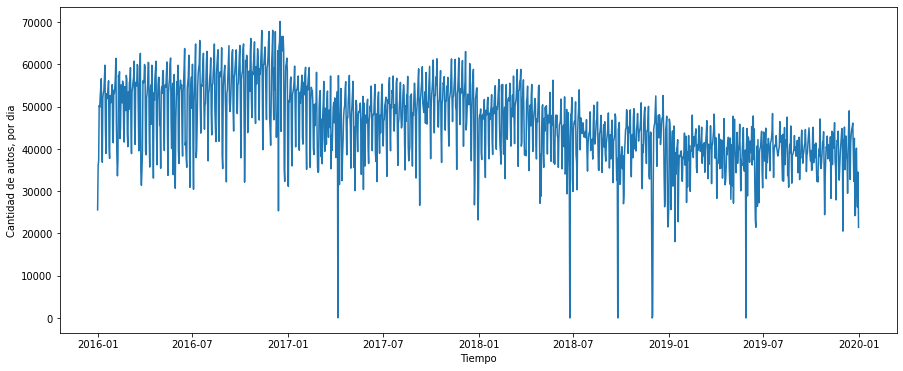

In [16]:
# Graficamos la serie resampleada 
plt.figure(figsize = (15,6))
plt.plot(diario.fecha, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Text(0, 0.5, 'Frecuencia')

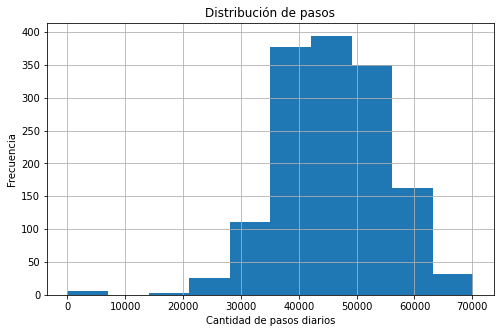

In [16]:
# Graficamos la distribución de la cantidad de pasos por dia
plt.rcParams['figure.figsize'] = [8,5]
diario['cantidad_pasos'].hist()
plt.title('Distribución de pasos')
plt.xlabel('Cantidad de pasos diarios')
plt.ylabel('Frecuencia')

In [17]:
# Verificar si la serie está completa
diario.fecha.diff().mean()

Timedelta('1 days 00:00:00')

In [18]:
# Verificar si la serie tiene valores nulos
diario.isnull().sum()

fecha             0
cantidad_pasos    0
dtype: int64

In [19]:
#Corregir valores atipicos de la serie

def valores_atipicos(df,ventana):
    '''Esta función identifica los valores atipicos de la serie en una ventana determinada mediante el z-score'''
    list_atipicos=[]
    samples=df.shape[0]
    if ventana >= samples:
        print('la venta es mayor al numero de muestras')
    else:
        n_max=samples//ventana
        for i in range(0+ventana,samples-ventana):
            media_ventana=df.loc[i-ventana:i+ventana+1,'cantidad_pasos'].mean()
            std_ventana=df.loc[i-ventana:i+ventana,'cantidad_pasos'].std()
            if (abs(df.loc[i,'cantidad_pasos']-media_ventana)/std_ventana)>=3:
                list_atipicos.append({i:df.loc[i,'cantidad_pasos']})
    return list_atipicos

def corregir_valores_atipicos(df,valores):
    '''Esta función actualiza el valor de la posción del valor atipico con el último valor del mismo tipo de día'''
    for i in valores:
        index=list(i.keys())
        df.loc[index[0],'cantidad_pasos']=df.loc[index[0]-7,'cantidad_pasos']
    return  df

def armar_dataset(df,nlags):
    '''Funcion para convertir una serie de tiempo en un dataset estructurado para modelos de machine learning'''
    df_aux=df.copy()
    for i in range(1,nlags+1):
        
        var="lag_"+str(i)
        df_aux[var]=df.shift(periods=i)
    return df_aux

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    
    is_max = s.max()
    is_min = s.min()

    list_color = []
    for k in s:
        if k == s.max():
            list_color.append('background-color: #FF2525')
        elif k == s.min():
            list_color.append('background-color: #99FF66')
        else:
            list_color.append('')
    return list_color

In [20]:
#Validamos los valores atipicos en una ventana de 14 dias 
valores_atipicos(diario,14)

[{461: 40},
 {618: 26656},
 {689: 35154},
 {906: 0},
 {998: 0},
 {1064: 0},
 {1065: 350},
 {1244: 0},
 {1430: 20553}]

In [21]:
# Corregimos los valores atipicos identificados previamente
diario_corr=corregir_valores_atipicos(diario,valores_atipicos(diario,14))

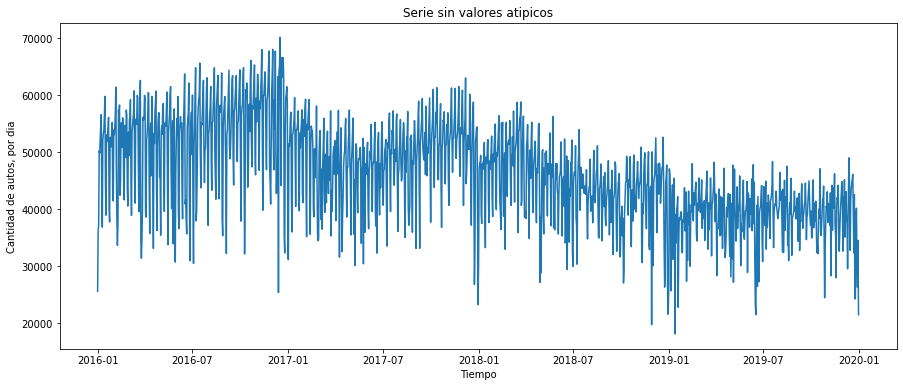

In [22]:
# Graficamos nuevamente la serie corregida
plt.figure(figsize = (15,6))
plt.plot(diario_corr.fecha, diario_corr.cantidad_pasos)
plt.title('Serie sin valores atipicos')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Text(0, 0.5, 'Frecuencia')

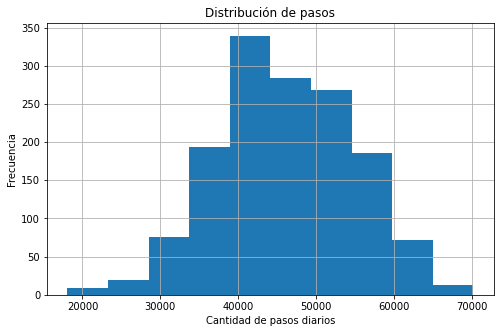

In [23]:
# Graficamos la distribución de la serie corregida
diario_corr['cantidad_pasos'].hist()
plt.title('Distribución de pasos')
plt.xlabel('Cantidad de pasos diarios')
plt.ylabel('Frecuencia')

## Componentes de la serie

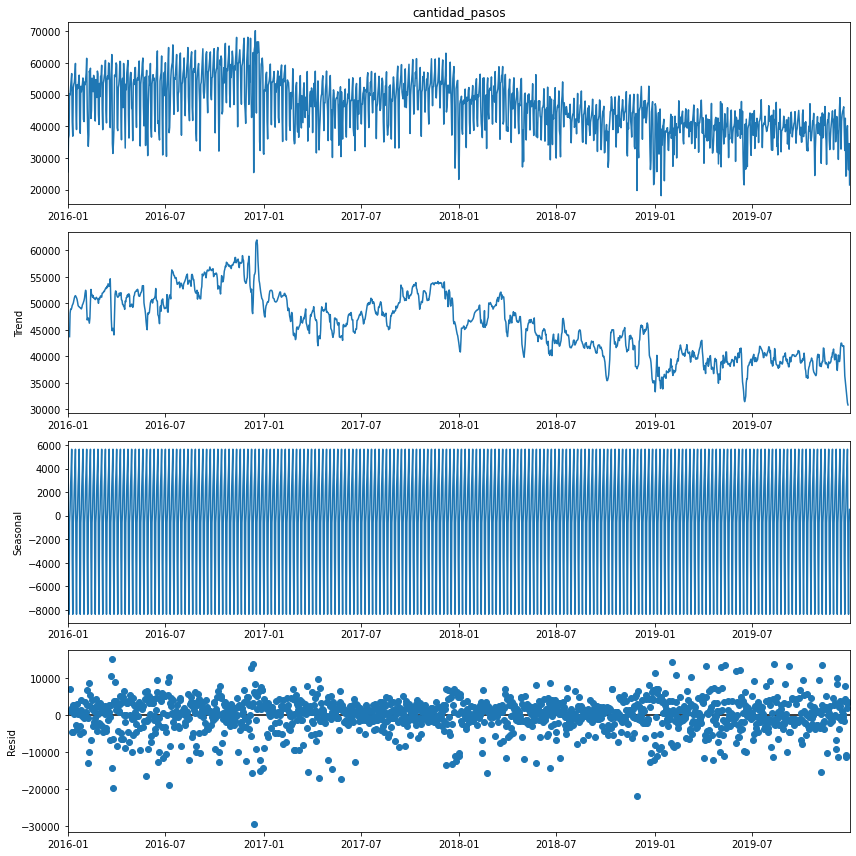

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = [12,12]

diario_corr.set_index('fecha',inplace=True)

result = seasonal_decompose(diario_corr.loc[:,'cantidad_pasos'], model='additive')
result.plot()
plt.show()

Text(0, 0.5, 'Frecuencia')

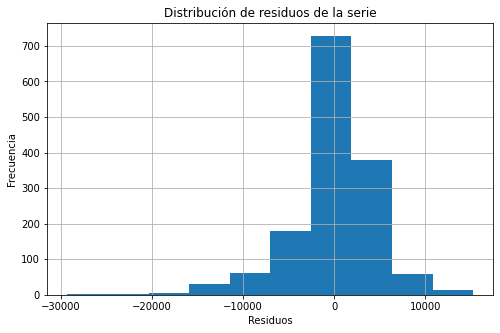

In [25]:
plt.rcParams['figure.figsize'] = [8,5]
result.resid.hist()
plt.title('Distribución de residuos de la serie')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')

# Analisis autocorrelaciones#

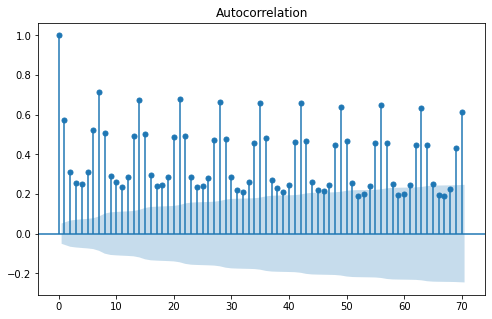

In [26]:
#Establecer número de lags a evaluar
nlags =  7*10

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diario_corr["cantidad_pasos"], lags = nlags)
plt.show()

En la grafico de autocorrelación se observa un valor de resago fuerte cada 7 días y se conserva a lo largo del tiempo en la ventana evaluada. Esto nos da un indicio de que el valor tk depende de en gran parte de lo ocurrido en los tk-7n donde n>0. 

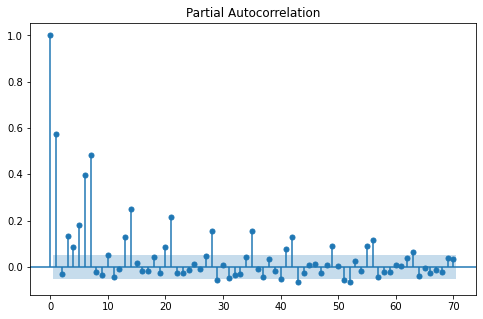

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diario_corr["cantidad_pasos"], lags = nlags)
plt.show()

En la grafico de autocorrelación parcial no se observa un valor de resago a lo largo del tiempo. 

# Implementación modelo benchmark #

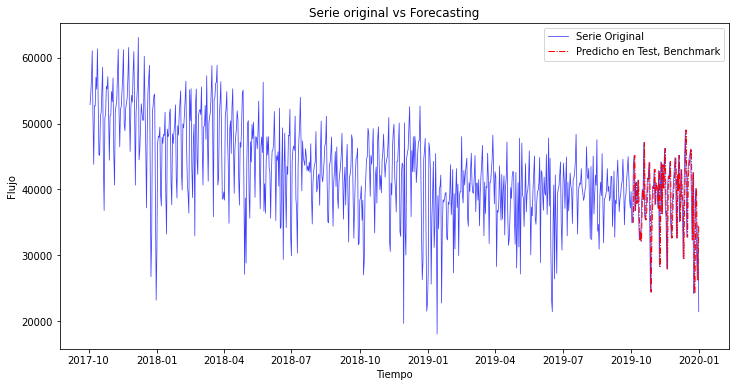

In [28]:
N_train = 2*365 # cantidad de instancias que vamos a usar para entrenar. 
N_test = 3*30 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test
L=diario_corr.shape[0]
y_bench=armar_dataset(diario_corr,1)
y_bench=y_bench.reset_index()

plt.figure(figsize=(12,6))
plt.plot(y_bench.loc[L-N_total:,'fecha'], y_bench.loc[L-N_total:,'cantidad_pasos'],c='b',lw = 0.75, alpha=0.75, label = 'Serie Original')
#plt.plot(y_bench.loc[:N_train-1,'fecha'], y_bench.loc[:N_train-1,'lag_1'],'-.', c='r',lw = 1,alpha=1, label = 'Predicho en Train, Benchmark')
plt.plot(y_bench.loc[L-N_test:,'fecha'], y_bench.loc[L-N_test:,'lag_1'],'-.', c='r',lw = 1, alpha=1,label = 'Predicho en Test, Benchmark')
plt.xlabel('Tiempo')
plt.ylabel('Flujo')
plt.title('Serie original vs Forecasting')
plt.legend()
plt.show()

In [29]:
# Calcular metrica de desempeño RMSE
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 

def evaluar_metricas(y_train,y_pred_train,y_test,y_pred_test,n_decimales):
    
    y_pred_train=np.nan_to_num(y_pred_train)

    rmse_train_bench = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),n_decimales)
    rmse_test_bench = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),n_decimales)

    # Calcular metrica de desempeño R^2
    r2_train_bench = round(r2_score(y_train, y_pred_train),n_decimales)
    r2_test_bench = round(r2_score(y_test, y_pred_test),n_decimales)

    # Calcular metrica de desempeño MAPE
    mape_train_bench = round(mean_absolute_percentage_error(y_train, y_pred_train),n_decimales)
    mape_test_bench = round(mean_absolute_percentage_error(y_test, y_pred_test),n_decimales)
    
    return [rmse_train_bench,rmse_test_bench,r2_train_bench,r2_test_bench,mape_train_bench,mape_test_bench]

In [30]:
results_bench=evaluar_metricas(y_bench.loc[L-N_total:L-N_test-1,'cantidad_pasos'],
                              y_bench.loc[L-N_total:L-N_test-1,'lag_1'],
                              y_bench.loc[L-N_test:,'cantidad_pasos'],
                              y_bench.loc[L-N_test:,'lag_1'],3)

results_bench

[6940.532, 6382.251, 0.077, -0.326, 13.128, 14.321]

In [31]:
dicc_errores={'Modelo':'Benchmark',
              'RMSE_Train':results_bench[0],
              'RMSE_Test':results_bench[1],
               r'$R^2 Train$':results_bench[2],
               r'$R^2 Test$':results_bench[3],
               'MAPE_Train':results_bench[4],
               'MAPE_Test':results_bench[5]}


df_errores=pd.DataFrame([dicc_errores])

df_errores.style.apply(highlight_max,subset=['RMSE_Train', 'RMSE_Test','MAPE_Train', 'MAPE_Test'])

,Modelo,RMSE_Train,RMSE_Test,$R^2 Train$,$R^2 Test$,MAPE_Train,MAPE_Test
0,Benchmark,6940.532000,6382.251000,0.077000,-0.326000,13.128000,14.321000


# Implementación modelo ARIMA #

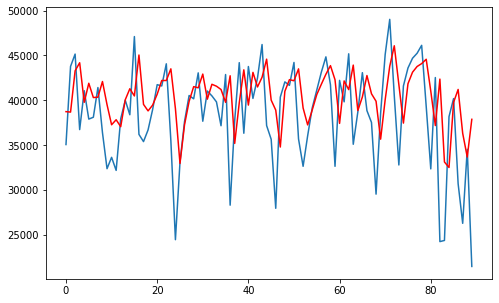

In [72]:
from statsmodels.tsa.arima.model import ARIMA
 
train= y_bench.loc[L-N_total:L-N_test-1,'cantidad_pasos'].values
test=y_bench.loc[L-N_test:,'cantidad_pasos'].values
history = train
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history=np.append(history,[obs])
    
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [74]:
results_arima=evaluar_metricas(y_bench.loc[L-N_total:L-N_test-1,'cantidad_pasos'],
                              model_fit.fittedvalues[:N_train],
                              y_bench.loc[L-N_test:,'cantidad_pasos'],
                              predictions,3)

results_arima.insert(0,'ARIMA_no_optimizado')

df_errores.loc[df_errores.shape[0]]=results_arima

df_errores.style.apply(highlight_max,subset=['RMSE_Train', 'RMSE_Test','MAPE_Train', 'MAPE_Test'])

,Modelo,RMSE_Train,RMSE_Test,$R^2 Train$,$R^2 Test$,MAPE_Train,MAPE_Test
0,Benchmark,6940.532000,6382.251000,0.077000,-0.326000,13.128000,14.321000
1,ARIMA_no_optimizado,6098.469000,5808.199000,0.288000,-0.098000,12.054000,13.130000


# Implementación Modelo Arima Recursivo - One step prediction #

In [75]:
df_grados=pd.read_csv(r"D:\Users\MIGUEL UPARELA\Google Drive\DATA_SCIENTIST\Curso Data Science Acamica\Bloque 3\Proyecto 3\grados_pol_arima.csv")

df_grados

,grados_p,grados_i,grados_q
0,0,0,1
1,0,0,2
2,0,0,3
3,0,1,1
4,0,1,2
5,0,1,3
6,1,0,0
7,1,0,1
8,1,0,2
9,1,0,3


In [76]:
list_aic=[]
for i in range(df_grados.shape[0]):
    print('Iteracion '+ str(i+1) + ' de ' + str(df_grados.shape[0]))
    try:
        model = ARIMA(train, order=(df_grados.iloc[i,0],df_grados.iloc[i,1],df_grados.iloc[i,2]),enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        list_aic.append(model_fit.aic)
    except:
        list_aic.append(np.nan)

Iteracion 1 de 30
Iteracion 2 de 30
Iteracion 3 de 30
Iteracion 4 de 30
Iteracion 5 de 30
Iteracion 6 de 30
Iteracion 7 de 30
Iteracion 8 de 30
Iteracion 9 de 30
Iteracion 10 de 30
Iteracion 11 de 30
Iteracion 12 de 30
Iteracion 13 de 30
Iteracion 14 de 30
Iteracion 15 de 30
Iteracion 16 de 30
Iteracion 17 de 30
Iteracion 18 de 30
Iteracion 19 de 30
Iteracion 20 de 30
Iteracion 21 de 30
Iteracion 22 de 30
Iteracion 23 de 30
Iteracion 24 de 30
Iteracion 25 de 30
Iteracion 26 de 30


C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Iteracion 27 de 30
Iteracion 28 de 30
Iteracion 29 de 30
Iteracion 30 de 30


In [77]:
df_grados['aic']=list_aic
df_grados.head()

,grados_p,grados_i,grados_q,aic
0,0,0,1,14802.393144
1,0,0,2,14762.600691
2,0,0,3,14743.774897
3,0,1,1,14703.650386
4,0,1,2,14598.989154


In [78]:
df_grados_mejores=df_grados.sort_values(by=['aic'],ascending=True).head()

df_grados_mejores

,grados_p,grados_i,grados_q,aic
29,3,1,3,14491.092286
25,3,0,3,14571.820046
5,0,1,3,14581.994653
28,3,1,2,14582.291054
21,2,1,3,14582.780159


In [79]:
list_predictions=[]
for i in range(df_grados_mejores.shape[0]):
    print('Iteracion '+ str(i+1) + ' de ' + str(df_grados_mejores.shape[0]))
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        try:
            model = ARIMA(history, 
                          order=(df_grados_mejores.iloc[i,0],df_grados_mejores.iloc[i,1],df_grados_mejores.iloc[i,2]),
                          enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
        except:
            print('Algo salió mal')
        
    list_predictions.append(predictions)

Iteracion 1 de 5
Iteracion 2 de 5


C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\USUARIO\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

Iteracion 3 de 5
Iteracion 4 de 5
Iteracion 5 de 5


In [80]:
list_mape=[]
for i in range(len(list_predictions)):
    results= round(mean_absolute_percentage_error(test, list_predictions[i]),3)
    list_mape.append(results)

In [81]:
df_grados_mejores['MAPE_Test']=list_mape

df_grados_mejores

,grados_p,grados_i,grados_q,aic,MAPE_Test
29,3,1,3,14491.092286,11.554
25,3,0,3,14571.820046,11.756
5,0,1,3,14581.994653,12.192
28,3,1,2,14582.291054,12.029
21,2,1,3,14582.780159,12.161


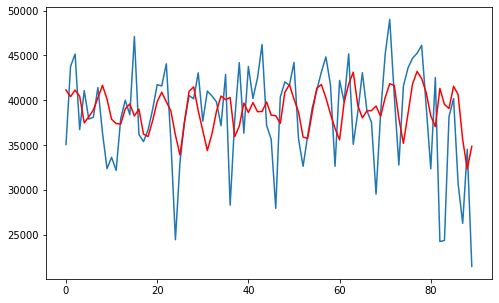

In [82]:
# Modelo ARIMA ganador
df_grados_mejores=df_grados_mejores.sort_values(by=['MAPE_Test'],ascending=True)

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    best_model_arima = ARIMA(history, 
                  order=(df_grados_mejores.iloc[0,0],df_grados_mejores.iloc[0,1],df_grados_mejores.iloc[0,2]),
                  enforce_stationarity=False, enforce_invertibility=False)
    best_model_arima_fit = best_model_arima.fit()
    output = best_model_arima_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [84]:
results_best_arima=evaluar_metricas(y_bench.loc[L-N_total:L-N_test-1,'cantidad_pasos'],
                              best_model_arima_fit.fittedvalues[:N_train],
                              y_bench.loc[L-N_test:,'cantidad_pasos'],
                              predictions,3)

results_best_arima.insert(0,'ARIMA_Optimizado')

df_errores.loc[df_errores.shape[0]]=results_best_arima

df_errores.style.apply(highlight_max,subset=['RMSE_Train', 'RMSE_Test','MAPE_Train', 'MAPE_Test'])

,Modelo,RMSE_Train,RMSE_Test,$R^2 Train$,$R^2 Test$,MAPE_Train,MAPE_Test
0,Benchmark,6940.532000,6382.251000,0.077000,-0.326000,13.128000,14.321000
1,ARIMA_no_optimizado,6098.469000,5808.199000,0.288000,-0.098000,12.054000,13.130000
2,ARIMA_Optimizado,5833.501000,5294.082000,0.348000,0.088000,10.258000,11.554000


In [85]:
# GUARDAR RESULTADOS Y MODELOS CORTE 1
import pickle

file_to_store = open("arima_optimizado.pickle", "wb")
pickle.dump(best_model_arima_fit, file_to_store)
file_to_store.close()

file_to_store = open("arima_no_optimizado.pickle", "wb")
pickle.dump(model_fit, file_to_store)
file_to_store.close()

file_to_store = open("resultados_2.pickle", "wb")
pickle.dump(df_errores, file_to_store)
file_to_store.close()

# Implementación Modelo RF sin optimizar#

In [87]:
n_lags=7*2
df_ml=armar_dataset(diario_corr,n_lags)
df_ml.reset_index(inplace=True)
df_ml.head(10)

,fecha,cantidad_pasos,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
0,2016-01-01,25574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,36113,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,37178,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,50281,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,49883,50281.0,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-01-06,52461,49883.0,50281.0,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-01-07,54452,52461.0,49883.0,50281.0,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2016-01-08,56616,54452.0,52461.0,49883.0,50281.0,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2016-01-09,41412,56616.0,54452.0,52461.0,49883.0,50281.0,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2016-01-10,36852,41412.0,56616.0,54452.0,52461.0,49883.0,50281.0,37178.0,36113.0,25574.0,NaN,NaN,NaN,NaN,NaN


In [91]:
df_ml_2=df_ml.loc[n_lags:,]
df_ml_2.head()

,fecha,cantidad_pasos,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
14,2016-01-15,59824,56335.0,53853.0,53280.0,52156.0,36852.0,41412.0,56616.0,54452.0,52461.0,49883.0,50281.0,37178.0,36113.0,25574.0
15,2016-01-16,44924,59824.0,56335.0,53853.0,53280.0,52156.0,36852.0,41412.0,56616.0,54452.0,52461.0,49883.0,50281.0,37178.0,36113.0
16,2016-01-17,38950,44924.0,59824.0,56335.0,53853.0,53280.0,52156.0,36852.0,41412.0,56616.0,54452.0,52461.0,49883.0,50281.0,37178.0
17,2016-01-18,53053,38950.0,44924.0,59824.0,56335.0,53853.0,53280.0,52156.0,36852.0,41412.0,56616.0,54452.0,52461.0,49883.0,50281.0
18,2016-01-19,51881,53053.0,38950.0,44924.0,59824.0,56335.0,53853.0,53280.0,52156.0,36852.0,41412.0,56616.0,54452.0,52461.0,49883.0


In [130]:
df_ml_2.tail()

,fecha,cantidad_pasos,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
1456,2019-12-27,40182,38168.0,24349.0,24220.0,42531.0,32337.0,39303.0,46128.0,45241.0,44687.0,43597.0,41588.0,32774.0,40478.0,49027.0
1457,2019-12-28,30681,40182.0,38168.0,24349.0,24220.0,42531.0,32337.0,39303.0,46128.0,45241.0,44687.0,43597.0,41588.0,32774.0,40478.0
1458,2019-12-29,26259,30681.0,40182.0,38168.0,24349.0,24220.0,42531.0,32337.0,39303.0,46128.0,45241.0,44687.0,43597.0,41588.0,32774.0
1459,2019-12-30,34523,26259.0,30681.0,40182.0,38168.0,24349.0,24220.0,42531.0,32337.0,39303.0,46128.0,45241.0,44687.0,43597.0,41588.0
1460,2019-12-31,21447,34523.0,26259.0,30681.0,40182.0,38168.0,24349.0,24220.0,42531.0,32337.0,39303.0,46128.0,45241.0,44687.0,43597.0


In [98]:
X=df_ml_2.iloc[:,2:].values

In [99]:
X

array([[56335., 53853., 53280., ..., 37178., 36113., 25574.],
       [59824., 56335., 53853., ..., 50281., 37178., 36113.],
       [44924., 59824., 56335., ..., 49883., 50281., 37178.],
       ...,
       [30681., 40182., 38168., ..., 43597., 41588., 32774.],
       [26259., 30681., 40182., ..., 44687., 43597., 41588.],
       [34523., 26259., 30681., ..., 45241., 44687., 43597.]])

In [100]:
y=df_ml_2.iloc[:,1].values

In [101]:
y

array([59824, 44924, 38950, ..., 26259, 34523, 21447], dtype=int64)

In [104]:
L=X.shape[0]
X_train,X_test=X[L-N_total:L-N_test],X[L-N_test:]
y_train,y_test=y[L-N_total:L-N_test],y[L-N_test:]

print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

730
90
730
90


In [105]:
tscv = TimeSeriesSplit(n_splits=5)

rf_r=RandomForestRegressor(random_state=42,n_jobs=-1)

rf_r_scores=cross_validate(rf_r,
                    X=X_train,
                    y=y_train,
                    cv=tscv, 
                    return_train_score=True, 
                    n_jobs = -1,
                    scoring='neg_mean_squared_error')

In [106]:
rf_r_scores

{'fit_time': array([0.26024556, 0.26024556, 0.26024556, 0.26223874, 0.2542479 ]),
 'score_time': array([0.10470343, 0.10470343, 0.10470343, 0.104702  , 0.10369778]),
 'test_score': array([-25446700.74014462, -21805261.86873884, -36977169.56946281,
        -28014277.47391901, -18503533.92075785]),
 'train_score': array([-3357321.9381768 , -3401147.59897439, -3171995.24156022,
        -3561977.8434916 , -3558386.38311182])}

In [107]:
# Entrenar modelo arboles
rf_r.fit(X_train,y_train)

# Realizar prediciones con los modelos entrenados : X_train
y_pred_train_rf = rf_r.predict(X_train)

# Realizar prediciones con los modelos entrenados
y_pred_test_rf = rf_r.predict(X_test)

In [108]:
results_rf=evaluar_metricas(y_train,
                              y_pred_train_rf,
                              y_test,
                              y_pred_test_rf,3)

results_rf.insert(0,'RandomForest_No_Optimizado')

df_errores.loc[df_errores.shape[0]]=results_rf

df_errores.style.apply(highlight_max,subset=['RMSE_Train', 'RMSE_Test','MAPE_Train', 'MAPE_Test'])

,Modelo,RMSE_Train,RMSE_Test,$R^2 Train$,$R^2 Test$,MAPE_Train,MAPE_Test
0,Benchmark,6940.532000,6382.251000,0.077000,-0.326000,13.128000,14.321000
1,ARIMA_no_optimizado,6098.469000,5808.199000,0.288000,-0.098000,12.054000,13.130000
2,ARIMA_Optimizado,5833.501000,5294.082000,0.348000,0.088000,10.258000,11.554000
3,RandomForest_No_Optimizado,1810.366000,4994.374000,0.937000,0.188000,3.417000,10.981000


# Implementación Modelo RF Optimizado #

In [109]:
# Numero de arboles
n_estimators = [int(x) for x in np.arange(200,320,20)]
# Profundidad de arboles
max_depth = [int(x) for x in np.arange(20,120,20)]
max_depth.append(None)

# Numero minimo de muestras para dividir un nodo intermedio
min_samples_split = [10,15,20]
# Numero minimo de muestras para dividir un nodo hoja
min_samples_leaf = [5,10,15]



# Grilla para RF
param_grid_rf = {'n_estimators': n_estimators,
               'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}

print(param_grid_rf)

{'n_estimators': [200, 220, 240, 260, 280, 300], 'max_depth': [20, 40, 60, 80, 100, None], 'min_samples_split': [10, 15, 20], 'min_samples_leaf': [5, 10, 15]}


In [110]:
rf_r=RandomForestRegressor(random_state=42,
                           n_jobs=-1)
grd_rf = GridSearchCV(rf_r,
                      return_train_score=True,
                      param_grid=param_grid_rf, 
                      cv=tscv,
                      n_jobs=-1,
                      scoring='neg_mean_squared_error')

In [111]:
grd_rf.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20, 40, 60, 80, 100, None],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [200, 220, 240, 260, 280, 300]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [112]:
file_to_store = open("rf_optimizado.pickle", "wb")
pickle.dump(grd_rf, file_to_store)
file_to_store.close()

In [113]:
# Realizar prediciones con los modelos entrenados : X_train
y_pred_train_grf = grd_rf.predict(X_train)

# Realizar prediciones con los modelos entrenados
y_pred_test_grf = grd_rf.predict(X_test)

In [114]:
results_grf=evaluar_metricas(y_train,
                              y_pred_train_grf,
                              y_test,
                              y_pred_test_grf,3)

results_grf.insert(0,'RandomForest_Optimizado')

df_errores.loc[df_errores.shape[0]]=results_grf

df_errores.style.apply(highlight_max,subset=['RMSE_Train', 'RMSE_Test','MAPE_Train', 'MAPE_Test'])

,Modelo,RMSE_Train,RMSE_Test,$R^2 Train$,$R^2 Test$,MAPE_Train,MAPE_Test
0,Benchmark,6940.532000,6382.251000,0.077000,-0.326000,13.128000,14.321000
1,ARIMA_no_optimizado,6098.469000,5808.199000,0.288000,-0.098000,12.054000,13.130000
2,ARIMA_Optimizado,5833.501000,5294.082000,0.348000,0.088000,10.258000,11.554000
3,RandomForest_No_Optimizado,1810.366000,4994.374000,0.937000,0.188000,3.417000,10.981000
4,RandomForest_Optimizado,3314.684000,4967.834000,0.790000,0.197000,6.182000,10.762000


De los resultados obtenidos para los distintos modelos probados se tienen los siguientes comentarios:

1. El modelo benchmark fue el que obtuvo el peor desempeño.
2. Los modelos estadisticos ARIMA tienden a generalizar mas el comportamiento de la serie de tiempo debido a que el gap entre el desempeño en Train y Test son significativamente mas bajo que en los modelos de Random Forests. 
2. Dentro de los dos modelos de Random Forests implementados el modelo no optimizado (con sus hiperparametros por defecto) obtuvo un desempeño alto en Train en comparación con el de Test. Esta situación nos indica que el modelo está sobreajustado.
3. Para los modelos ARIMA la optimización recursiva proporcionó un desempeño más estable que el no optimizado.

Teniendo en cuenta las observaciones anteriores seleccionaria el modelo ARIMA optimizado como mi mejor modelo dado que generaliza más el comportamiento de la serie de tiempo. Sin embargo, al tratarse de un curso de ML escojo el modelo de Random Forest Optimizado para predecir el año 2020.

# Predición año 2020 # 


In [115]:
best_model_arima_fit = pickle.load( open( "arima_optimizado.pickle", "rb" ) )

model_arima_fit = pickle.load( open( "arima_no_optimizado.pickle", "rb" ) )

model_arima_fit = pickle.load( open( "arima_no_optimizado.pickle", "rb" ) )

grd_rf =pickle.load( open( "rf_optimizado.pickle", "rb" ) )

In [116]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [117]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847933 entries, 0 to 1847932
Data columns (total 13 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   mes             object
 3   dia             object
 4   dia_fecha       int64 
 5   hora_inicio     int64 
 6   hora_fin        int64 
 7   estacion        object
 8   tipo_vehiculo   object
 9   forma_pago      object
 10  observacion     object
 11  sentido         object
 12  cantidad_pasos  int64 
dtypes: int64(5), object(8)
memory usage: 183.3+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Centro,24
1,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80
2,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1
3,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1
4,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1


In [118]:
print('Valores unicos columna estacion: ')
print(data_2020['estacion'].value_counts())

Valores unicos columna estacion: 
AVELLANEDA                          399602
ILP                                 219426
ILLIA                               215490
DELLEPIANE LINIERSLEPIANE CENTRO    182586
DELLEPIANE LINIERS                  180588
ALBERDI                             139270
PB1                                 120224
PB4                                 108538
PB2                                  81200
RETIRO                               71109
PB3                                  59796
SALGUERO                             36318
SARMIENTO                            33786
Name: estacion, dtype: int64


In [119]:
print('Valores unicos columna forma de pago: ')
print(data_2020['forma_pago'].value_counts())

Valores unicos columna forma de pago: 
Tag                  1045096
Violación             312230
Efectivo              196304
Rec.Deuda             130578
Exento                110340
Tarjeta Magnética      36006
CPP                    17379
Name: forma_pago, dtype: int64


In [120]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020_n = data_2020[mask]
data_2020_n=data_2020_n.drop_duplicates()

#Quitamos las columnas que no vamos a utilizar
data_2020_n.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

data_2020_n.head()

,fecha,mes,dia,dia_fecha,hora_fin,tipo_vehiculo,observacion,sentido,cantidad_pasos
52,2020-01-01 00:00:00,enero,Miércoles,1,1,Auto,Efectivo,Centro,326
53,2020-01-01 00:00:00,enero,Miércoles,1,1,Auto,Efectivo,Provincia,319
134,2020-01-01 00:00:00,enero,Miércoles,1,2,Auto,Efectivo,Centro,199
135,2020-01-01 00:00:00,enero,Miércoles,1,2,Auto,Efectivo,Provincia,180
202,2020-01-01 00:00:00,enero,Miércoles,1,3,Auto,Efectivo,Centro,114


In [121]:
data_2020_n.shape

(39072, 9)

In [122]:
# Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020_n['fecha2'] = pd.to_datetime(data_2020_n.fecha) + pd.to_timedelta(data_2020_n.hora_fin, unit = 'h')


# Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020_n.drop(columns=['fecha','hora_fin'], inplace = True)


# Corregimos el nombre de fecha2 a fecha
data_2020_n.rename(columns = {'fecha2':'fecha'}, inplace = True)


#Reordenamos el dataset por fecha
data_2020_n.sort_values('fecha', inplace = True)


data_2020_n.reset_index(drop=True, inplace = True)

data_2020_n.head()

,mes,dia,dia_fecha,tipo_vehiculo,observacion,sentido,cantidad_pasos,fecha
0,enero,Miércoles,1,Auto,Efectivo,Centro,467,2020-01-01
1,enero,Miércoles,1,Moto,Efectivo,Centro,7,2020-01-01
2,enero,Miércoles,1,Auto,Efectivo,Provincia,423,2020-01-01
3,enero,Miércoles,1,Moto,Efectivo,Provincia,6,2020-01-01
4,enero,Miércoles,1,Pesados 2 Ejes,Efectivo,Centro,1,2020-01-01


In [123]:
data_2020_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39072 entries, 0 to 39071
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   mes             39072 non-null  object        
 1   dia             39072 non-null  object        
 2   dia_fecha       39072 non-null  int64         
 3   tipo_vehiculo   39072 non-null  object        
 4   observacion     39072 non-null  object        
 5   sentido         39072 non-null  object        
 6   cantidad_pasos  39072 non-null  int64         
 7   fecha           39072 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 2.4+ MB


In [124]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_2020 = data_2020_n.resample('D', on = 'fecha').sum()
diario_2020.reset_index(inplace=True)
print(diario_2020.shape)
diario_2020.head()

(274, 3)


,fecha,dia_fecha,cantidad_pasos
0,2020-01-01,184,21395
1,2020-01-02,408,33722
2,2020-01-03,618,37067
3,2020-01-04,824,30627
4,2020-01-05,1085,27812


In [125]:
diario_2020.drop(columns=['dia_fecha'],inplace=True)
diario_2020.head()

,fecha,cantidad_pasos
0,2020-01-01,21395
1,2020-01-02,33722
2,2020-01-03,37067
3,2020-01-04,30627
4,2020-01-05,27812


In [126]:
# Verificar si la serie está completa
diario_2020.fecha.diff().mean()

Timedelta('1 days 00:00:00')

In [127]:
# Verificar si la serie tiene valores nulos
diario_2020.isnull().sum()

fecha             0
cantidad_pasos    0
dtype: int64

In [128]:
n_2020=diario_2020.shape[0]
n_2020

274

In [ ]:
df_ml_2

In [132]:
y_pred_2020=[]
X_last=X[-1,:]
print(X_last)
for i in range(n_2020):
    y_hat=grd_rf.predict(X_last.reshape(1, -1))
    y_pred_2020.append(y_hat)
    X_last[:-1]=X_last[1:]
    X_last[-1]=y_hat

[34523. 26259. 30681. 40182. 38168. 24349. 24220. 42531. 32337. 39303.
 46128. 45241. 44687. 43597.]


In [133]:
diario_2020['cantidad_pasos_pred']=np.array(y_pred_2020)

diario_2020.head()

,fecha,cantidad_pasos,cantidad_pasos_pred
0,2020-01-01,21395,35701.783902
1,2020-01-02,33722,36881.513280
2,2020-01-03,37067,35098.749764
3,2020-01-04,30627,39659.987568
4,2020-01-05,27812,40011.347260


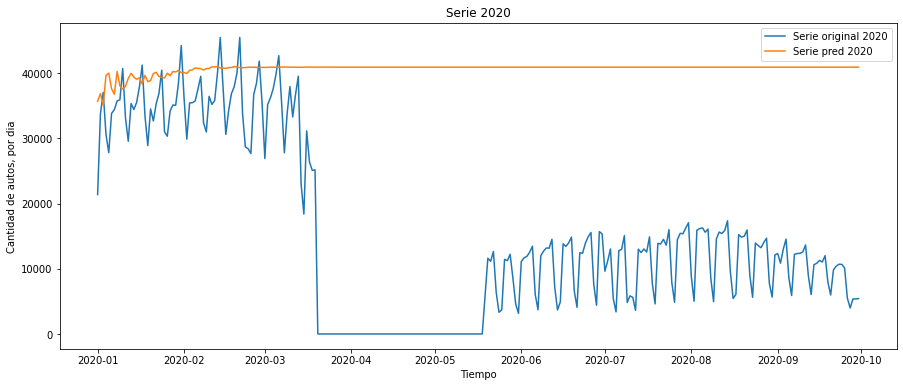

In [134]:
# Graficamos nuevamente la serie corregida
plt.figure(figsize = (15,6))
plt.plot(diario_2020.fecha, diario_2020.cantidad_pasos,label='Serie original 2020')
plt.plot(diario_2020.fecha, diario_2020.cantidad_pasos_pred,label='Serie pred 2020')
plt.title('Serie 2020')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.legend()
plt.show()

En la predicción de la cantidad de pasaos para el año 2020 se observa un error muy alto en mi opinión por los siguientes factores:

1. El año 2020 se ve observa un comportamiento atipico ocasionado por la pandemia mundial producto del covid-19. Esta situación mundial hizo que el comportamiento de la serie cambiara drasticamente y dado que en los datos utilizados para entrenar el modelo no hubo un comportamiento similar este no está en capacidad de predecir estas variaciones.

2. A pesar de que el Random Forest optimizado fue el mejor modelo entre los probados, no se utilizó todo el potencial de este tipo de modelo de machine learning, puesto que, basicamente el modelo se ajustó de forma similar a una regresión lineal.

# Investigación #

**Ideas a probar:**

1. Inicialmente me gustaría incorporar otro tipo de variables propias del dataset en los modelos de machine learning.
2. Tambien me gustaría probar otro tipo de modelos como XGBOOST, Redes neuronales y/o SARIMA.
3. Por otro lado, probaría implementar en la etapa de preprocesamiento la técnica de Feature engineering en la cual pudiera adicionar variables diferentes a las propias del dataset ya sea a partir de una transformación de variables propias o adicionar variables externas. Como por ejemplo: el tipo de día, si el día es festivo, entre otras.
4. Finalmente, me gustaría implementar un metamodelo el cual estuviera compuesto por 7 modelos los cuales cada uno se encargarian de predecir un tipo de dia en especifico.

**Resultados esperados:**
Teniendo en cuenta la implementación de las ideas anteriomente mencionadas, esperaría que los resultados se mejoraran de forma abrupta tanto en el conjunto de entrenamiento como en el de validación. Sin embargo, sabiendo que el 2020 el comportamiento de la serie es atipico no esperaría que la predición en esta ventana de tiempo mejorara. 